In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

fahimarefin99_sm_tec_generated_dataset_path = kagglehub.dataset_download('fahimarefin99/sm-tec-generated-dataset')

print('Data source import complete.')


# Neural Networks: Implement a Custom Artificial Neural Network (ANN).

Necessary Packages to Import
--

In [ ]:
import os
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from itertools import cycle



# Set up logging

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")



Custom Ann model Architecture
--

In [ ]:
class AdvancedNLIModel(nn.Module):
    def __init__(self, tfidf_input_dim, w2v_input_dim, num_classes=3, dropout_rate=0.2):
        super(AdvancedNLIModel, self).__init__()
        # Feature extraction dimensions (simplified)
        self.tfidf_hidden_dim = 256
        self.w2v_hidden_dim = 128
        # TF-IDF branch (simplified and more regularized)
        self.tfidf_branch = nn.Sequential(
            nn.Linear(tfidf_input_dim, self.tfidf_hidden_dim),
            nn.BatchNorm1d(self.tfidf_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(self.tfidf_hidden_dim, self.tfidf_hidden_dim),
            nn.BatchNorm1d(self.tfidf_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        # Word2Vec branch (simplified and more regularized)
        self.w2v_branch = nn.Sequential(
            nn.Linear(w2v_input_dim, self.w2v_hidden_dim),
            nn.BatchNorm1d(self.w2v_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(self.w2v_hidden_dim, self.w2v_hidden_dim),
            nn.BatchNorm1d(self.w2v_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        # Simplified feature fusion
        combined_dim = self.tfidf_hidden_dim + self.w2v_hidden_dim
        # Multi-head attention for feature interaction
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=combined_dim,
            num_heads=4,
            dropout=dropout_rate
        )
        # Classifier with deeper architecture
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, combined_dim // 2),
            nn.BatchNorm1d(combined_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(combined_dim // 2, combined_dim // 4),
            nn.BatchNorm1d(combined_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(combined_dim // 4, num_classes)
        )

    def forward(self, tfidf_input, w2v_input):
        # Feature extraction
        tfidf_features = self.tfidf_branch(tfidf_input)
        w2v_features = self.w2v_branch(w2v_input)
        # Concatenation of TF-IDF and Word2Vec features
        combined = torch.cat([tfidf_features, w2v_features], dim=1)
        # Apply multi-head attention
        combined_reshaped = combined.unsqueeze(0)  # Add sequence dimension
        attn_output, _ = self.cross_attention(combined_reshaped, combined_reshaped, combined_reshaped)
        attn_output = attn_output.squeeze(0)  # Remove sequence dimension
        # Residual connection
        enhanced_features = attn_output + combined
        # Classification
        output = self.classifier(enhanced_features)
        return output

# load and prepare data

In [ ]:
def load_and_prepare_data(data_dir='/kaggle/input/sm-tec-generated-dataset/'):
    """Load, preprocess and prepare data with enhanced processing."""
    logger.info("Loading preprocessed data...")
    processed_train = pd.read_csv(os.path.join(data_dir, 'multilingual_processed_train_text.csv'))
    processed_val = pd.read_csv(os.path.join(data_dir, 'multilingual_processed_val_text.csv'))

    logger.info("Loading TF-IDF features...")
    train_tfidf = np.load(os.path.join(data_dir, 'multilingual_train_tfidf_features.npy'))
    val_tfidf = np.load(os.path.join(data_dir, 'multilingual_val_tfidf_features.npy'))

    logger.info("Loading Word2Vec features...")
    train_premise_w2v = np.load(os.path.join(data_dir, 'multilingual_train_premise_w2v.npy'))
    train_hypothesis_w2v = np.load(os.path.join(data_dir, 'multilingual_train_hypothesis_w2v.npy'))
    val_premise_w2v = np.load(os.path.join(data_dir, 'multilingual_val_premise_w2v.npy'))
    val_hypothesis_w2v = np.load(os.path.join(data_dir, 'multilingual_val_hypothesis_w2v.npy'))

    # Check for NaN/Inf values in input features
    logger.info("Checking for NaN/Inf values in features...")
    if np.isnan(train_tfidf).any() or np.isinf(train_tfidf).any():
        logger.warning("Found NaN/Inf values in train_tfidf. Filling with zeros...")
        train_tfidf = np.nan_to_num(train_tfidf, nan=0.0, posinf=0.0, neginf=0.0)
    if np.isnan(val_tfidf).any() or np.isinf(val_tfidf).any():
        logger.warning("Found NaN/Inf values in val_tfidf. Filling with zeros...")
        val_tfidf = np.nan_to_num(val_tfidf, nan=0.0, posinf=0.0, neginf=0.0)

    # Feature selection for TF-IDF - keep only top features by variance
    logger.info("Performing TF-IDF feature selection...")
    from sklearn.feature_selection import VarianceThreshold

    # Remove near-zero variance features
    selector = VarianceThreshold(threshold=0.001)
    train_tfidf_selected = selector.fit_transform(train_tfidf)
    val_tfidf_selected = selector.transform(val_tfidf)

    logger.info(f"Reduced TF-IDF features from {train_tfidf.shape[1]} to {train_tfidf_selected.shape[1]}")

    # Normalize TF-IDF features with robust scaling
    logger.info("Normalizing TF-IDF features with robust scaling...")
    from sklearn.preprocessing import RobustScaler

    tfidf_scaler = RobustScaler()  # Less affected by outliers
    train_tfidf = tfidf_scaler.fit_transform(train_tfidf_selected)
    val_tfidf = tfidf_scaler.transform(val_tfidf_selected)

    # Normalize Word2Vec features
    logger.info("Normalizing Word2Vec features...")
    w2v_scaler = RobustScaler()
    train_premise_w2v = w2v_scaler.fit_transform(train_premise_w2v)
    train_hypothesis_w2v = w2v_scaler.transform(train_hypothesis_w2v)
    val_premise_w2v = w2v_scaler.transform(val_premise_w2v)
    val_hypothesis_w2v = w2v_scaler.transform(val_hypothesis_w2v)

    # Enhanced feature combination for Word2Vec with additional relationship features
    logger.info("Combining Word2Vec features with enhanced relationship features...")
    train_w2v_combined = np.concatenate([
        train_premise_w2v,
        train_hypothesis_w2v,
        np.abs(train_premise_w2v - train_hypothesis_w2v),  # Absolute difference
        np.multiply(train_premise_w2v, train_hypothesis_w2v),  # Element-wise product

        # Additional semantic relationship features
        np.maximum(train_premise_w2v, train_hypothesis_w2v),  # Element-wise max
        np.minimum(train_premise_w2v, train_hypothesis_w2v),  # Element-wise min

        # Normalized difference to capture direction regardless of magnitude
        np.tanh(train_premise_w2v - train_hypothesis_w2v),

        # Squared difference to emphasize large discrepancies
        np.square(train_premise_w2v - train_hypothesis_w2v)
    ], axis=1)

    val_w2v_combined = np.concatenate([
        val_premise_w2v,
        val_hypothesis_w2v,
        np.abs(val_premise_w2v - val_hypothesis_w2v),
        np.multiply(val_premise_w2v, val_hypothesis_w2v),

        # Additional semantic relationship features
        np.maximum(val_premise_w2v, val_hypothesis_w2v),
        np.minimum(val_premise_w2v, val_hypothesis_w2v),

        # Normalized difference
        np.tanh(val_premise_w2v - val_hypothesis_w2v),

        # Squared difference
        np.square(val_premise_w2v - val_hypothesis_w2v)
    ], axis=1)

    # Check shapes for debugging
    logger.info(f"Processed shapes:")
    logger.info(f"train_tfidf: {train_tfidf.shape}")
    logger.info(f"val_tfidf: {val_tfidf.shape}")
    logger.info(f"train_w2v_combined: {train_w2v_combined.shape}")
    logger.info(f"val_w2v_combined: {val_w2v_combined.shape}")

    # Prepare labels
    train_labels = processed_train['label'].values
    val_labels = processed_val['label'].values

    # Check for and handle NaN values
    if np.isnan(train_labels).any():
        logger.warning(f"Found {np.isnan(train_labels).sum()} NaN values in train_labels. Filling with 1...")
        train_labels = np.nan_to_num(train_labels, nan=1)
    if np.isnan(val_labels).any():
        logger.warning(f"Found {np.isnan(val_labels).sum()} NaN values in val_labels. Filling with 1...")
        val_labels = np.nan_to_num(val_labels, nan=1)

    # Convert labels to integer type (ensure they're 0, 1, 2)
    train_labels = train_labels.astype(np.int64)
    val_labels = val_labels.astype(np.int64)

    # Implement stratified oversampling to handle class imbalance
    logger.info("Applying stratified oversampling for class balance...")
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=SEED)

    # Flatten the features for SMOTE
    train_combined = np.concatenate([train_tfidf, train_w2v_combined], axis=1)

    # Apply SMOTE only if the minority class has enough samples
    if np.min(np.bincount(train_labels)) >= 5:
        train_combined_resampled, train_labels_resampled = smote.fit_resample(train_combined, train_labels)

        # Split back the resampled features
        tfidf_dim = train_tfidf.shape[1]
        train_tfidf_resampled = train_combined_resampled[:, :tfidf_dim]
        train_w2v_combined_resampled = train_combined_resampled[:, tfidf_dim:]

        # Update the variables
        train_tfidf = train_tfidf_resampled
        train_w2v_combined = train_w2v_combined_resampled
        train_labels = train_labels_resampled

    # Compute class weights for any remaining imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = torch.FloatTensor(class_weights)
    logger.info(f"Class weights: {class_weights}")

    # Define label map for interpretation
    label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}

    # Create datasets
    train_dataset = NLIDataset(train_tfidf, train_w2v_combined, train_labels)
    val_dataset = NLIDataset(val_tfidf, val_w2v_combined, val_labels)

    return {
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'tfidf_dim': train_tfidf.shape[1],
        'w2v_dim': train_w2v_combined.shape[1],
        'class_weights': class_weights,
        'label_map': label_map
    }



# Validation function

In [ ]:
def validate(model, data_loader, criterion, return_predictions=False):
    """Validate the model and compute metrics."""
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for tfidf_inputs, w2v_inputs, labels in data_loader:
            tfidf_inputs = tfidf_inputs.to(device)
            w2v_inputs = w2v_inputs.to(device)
            labels = labels.to(device)

            outputs = model(tfidf_inputs, w2v_inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_probs.append(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(data_loader.dataset)
    all_probs = np.vstack(all_probs)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    if return_predictions:
        return val_loss, accuracy, f1, all_preds, all_labels, all_probs
    else:
        return val_loss, accuracy, f1



# Plot training history

In [ ]:
def plot_training_history(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 8))

    # Plot training & validation loss
    plt.subplot(2, 1, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot Accuracy and F1
    plt.subplot(2, 1, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.plot(history['val_f1'], label='Validation F1')
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_score, classes):
    """Plot ROC curve for multiclass classification."""
    n_classes = len(classes)
    y_true_bin = np.eye(n_classes)[y_true]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(12, 10))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Return the AUC scores
    return roc_auc



# Model Trainning configuration
--

In [ ]:
def train_model(data_info, batch_size=32, num_epochs=200, learning_rate=0.0003):
    """Train model with improved training pipeline including evaluation."""
    # Create data loaders with better worker configuration
    train_loader = DataLoader(
        data_info['train_dataset'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True if torch.cuda.is_available() else False,
        drop_last=True  # Avoid issues with single-sample batches
    )

    val_loader = DataLoader(
        data_info['val_dataset'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # Initialize model
    model = AdvancedNLIModel(
        tfidf_input_dim=data_info['tfidf_dim'],
        w2v_input_dim=data_info['w2v_dim'],
        num_classes=3,
        dropout_rate=0.2  # Reduced dropout
    ).to(device)

    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

    # Loss function with modified class weights and label smoothing
    # Label smoothing helps prevent overconfidence
    class_weights = data_info['class_weights']
    # Fix: Move class_weights to the same device as the model
    class_weights = class_weights.to(device) if class_weights is not None else None
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

    # Improved optimizer with lower learning rate and weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01,  # Increased weight decay for regularization
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # Learning rate scheduler - One-cycle policy works better than ReduceLROnPlateau
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,  # Warm-up for 30% of training
        div_factor=25,
        final_div_factor=1000
    )

    # Early stopping
    best_val_f1 = 0.0
    patience = 7  # Increased patience
    patience_counter = 0

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    logger.info(f"Starting training with {num_epochs} epochs...")
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Training loop with mixed precision
        for i, (tfidf_inputs, w2v_inputs, labels) in enumerate(train_loader):
            tfidf_inputs = tfidf_inputs.to(device)
            w2v_inputs = w2v_inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Mixed precision forward pass
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(tfidf_inputs, w2v_inputs)
                    loss = criterion(outputs, labels)

                # Backward pass with gradient scaling
                scaler.scale(loss).backward()

                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Update weights
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard forward pass if not using mixed precision
                outputs = model(tfidf_inputs, w2v_inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Update LR
            scheduler.step()

            # Track statistics
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            # Print batch progress (less frequently)
            if (i+1) % 100 == 0:
                logger.info(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, '
                           f'Loss: {loss.item():.4f}')

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validate
        val_loss, val_acc, val_f1 = validate(model, val_loader, criterion)

        # Save history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Print epoch results
        epoch_time = time.time() - epoch_start
        logger.info(f'Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.1f}s - '
                   f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
                   f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

        # Check for improvement
        if val_f1 > best_val_f1:
            logger.info(f'Validation F1 improved from {best_val_f1:.4f} to {val_f1:.4f}')
            best_val_f1 = val_f1
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
                'val_acc': val_acc,
            }, 'best_model_improved.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            logger.info(f'No improvement in validation F1. Patience: {patience_counter}/{patience}')

        # Early stopping
        if patience_counter >= patience:
            logger.info(f'Early stopping at epoch {epoch+1}')
            break

    total_time = time.time() - start_time
    logger.info(f'Training completed in {total_time/60:.2f} minutes')

    # Load best model
    checkpoint = torch.load('best_model_improved.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    logger.info(f"Loaded best model from epoch {checkpoint['epoch']+1} with "
               f"val_f1={checkpoint['val_f1']:.4f}, val_acc={checkpoint['val_acc']:.4f}")

    return model, history, val_loader, criterion, data_info

# Evaluate model and print metrics

In [ ]:
def evaluate_model(model, val_loader, criterion, data_info):
    """Evaluate model and print detailed metrics."""
    # Get predictions and probabilities
    val_loss, accuracy, f1, all_preds, all_labels, all_probs = validate(
        model, val_loader, criterion, return_predictions=True
    )

    # Get class names
    class_names = [data_info['label_map'][i] for i in range(3)]

    # Print metrics
    print("\n====================== MODEL EVALUATION ======================")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {f1:.4f}")

    # Calculate precision and recall for each class
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    print("\n================= PER-CLASS METRICS =================")
    for i, class_name in enumerate(class_names):
        print(f"Class: {class_name}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1_per_class[i]:.4f}")

    # Print classification report
    print("\n================= CLASSIFICATION REPORT =================")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    print("\n================= CONFUSION MATRIX =================")
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Plot ROC curves
    print("\n================= ROC CURVES =================")
    roc_auc = plot_roc_curve(all_labels, all_probs, class_names)

    # Print ROC-AUC scores
    print("\nROC-AUC Scores:")
    print(f"Micro-average: {roc_auc['micro']:.4f}")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {roc_auc[i]:.4f}")

    return {
        'loss': val_loss,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'predictions': all_preds,
        'true_labels': all_labels,
        'probabilities': all_probs
    }


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
data_info = load_and_prepare_data()

# Make sure class_weights are properly initialized
if 'class_weights' in data_info and data_info['class_weights'] is not None:
    data_info['class_weights'] = data_info['class_weights'].to(device)




# Train the model

In [ ]:
model, history, val_loader, criterion, data_info = train_model(
    data_info,
    batch_size=64,
    num_epochs=200,
    learning_rate=0.001
)

<ipython-input-113-fc1709eb6880>:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
<ipython-input-113-fc1709eb6880>:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-113-fc1709eb6880>:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-113-fc1709eb6880>:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-113-fc1709eb6880>:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cud

# Plot training history


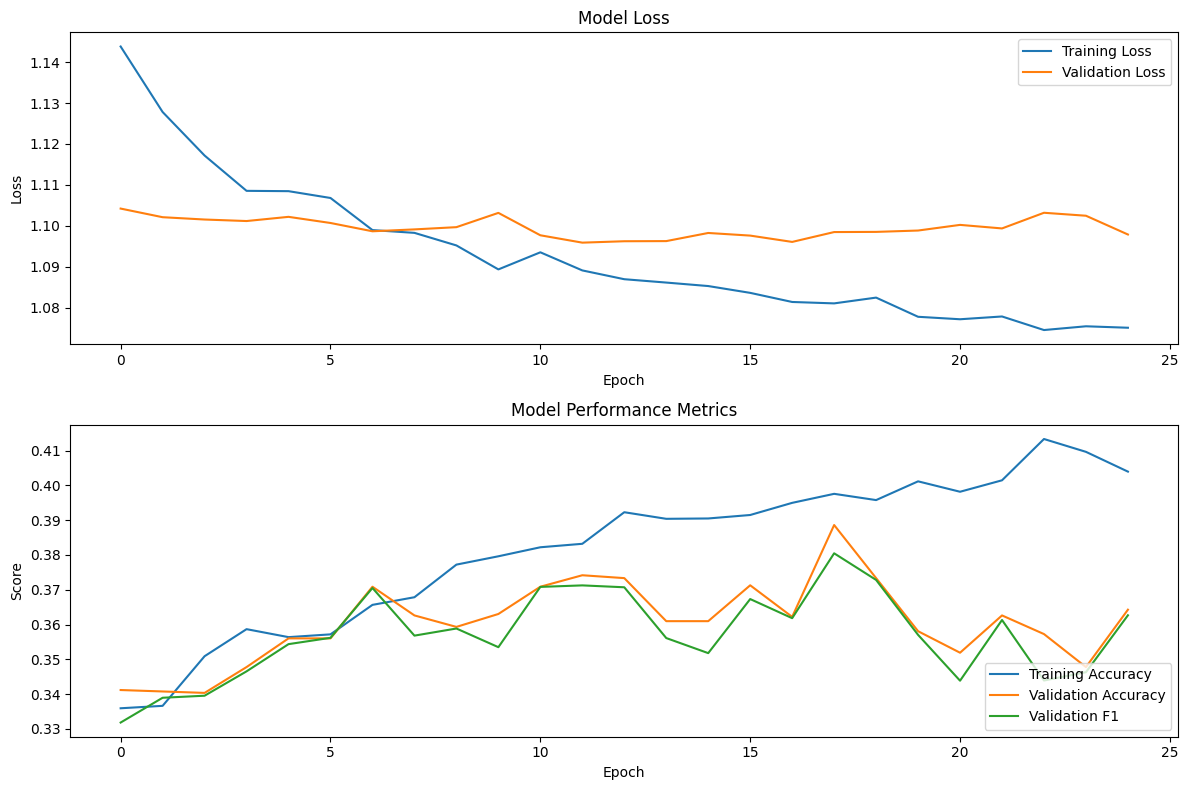

In [ ]:
plot_training_history(history)

# Evaluate the model with detailed metrics


====================== MODEL EVALUATION ======================
Validation Loss: 1.0985
Accuracy: 0.3886
Macro F1 Score: 0.3805

================= PER-CLASS METRICS =================
Class: entailment
  Precision: 0.4157
  Recall: 0.3928
  F1 Score: 0.4039
Class: neutral
  Precision: 0.3729
  Recall: 0.5348
  F1 Score: 0.4394
Class: contradiction
  Precision: 0.3812
  Recall: 0.2448
  F1 Score: 0.2981

================= CLASSIFICATION REPORT =================
               precision    recall  f1-score   support

   entailment       0.42      0.39      0.40       835
      neutral       0.37      0.53      0.44       776
contradiction       0.38      0.24      0.30       813

     accuracy                           0.39      2424
    macro avg       0.39      0.39      0.38      2424
 weighted avg       0.39      0.39      0.38      2424


================= CONFUSION MATRIX =================


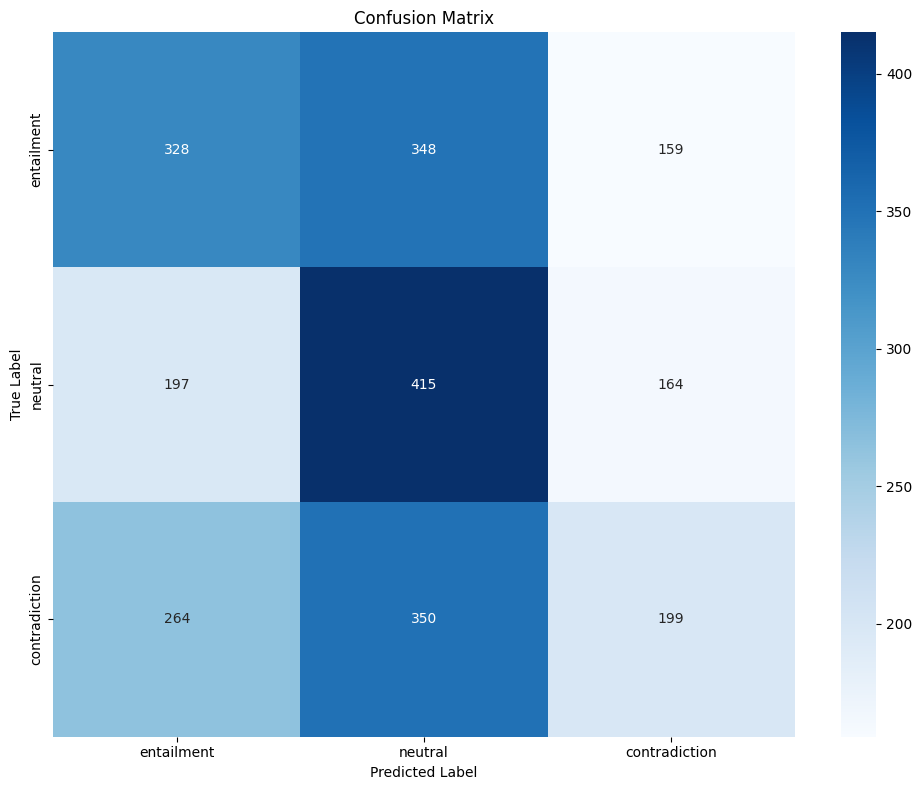


================= ROC CURVES =================


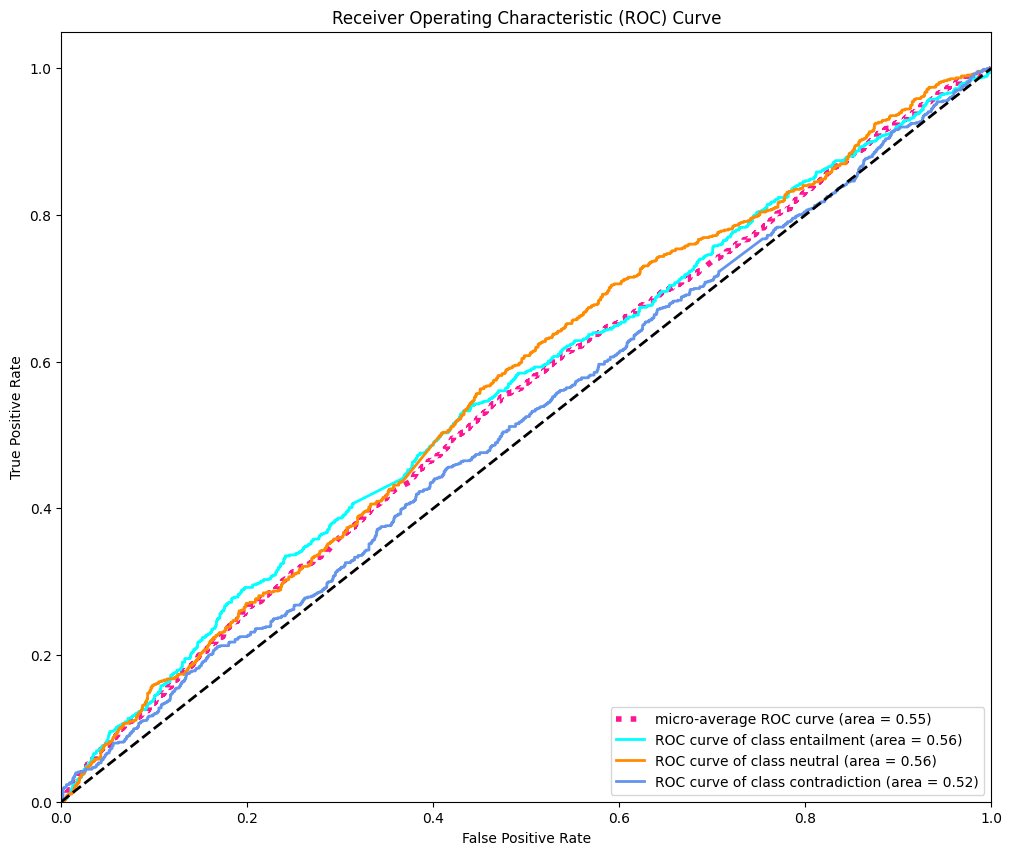


ROC-AUC Scores:
Micro-average: 0.5461
entailment: 0.5573
neutral: 0.5632
contradiction: 0.5183


In [ ]:
evaluation_results = evaluate_model(model, val_loader, criterion, data_info)